libraries

In [95]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

upload image

In [96]:
img = cv2.imread("test.jpg")
output = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 30, 90)


contour

In [97]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

color fun

In [98]:
def detect_color_by_mask(hsv, contour):
    mask = np.zeros(hsv.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)


    color_ranges = {
        "red": [(0, 70, 50), (10, 255, 255), (170, 70, 50), (180, 255, 255)],
       "yellow": [(18, 80, 80), (38, 255, 255)],
        "green": [(40, 50, 50), (85, 255, 255)],
        "blue": [(90, 50, 50), (130, 255, 255)],
        "white": [(0, 0, 200), (180, 30, 255)]
    }

    for color, ranges in color_ranges.items():
        if color == "red":
            lower1, upper1, lower2, upper2 = ranges
            mask1 = cv2.inRange(hsv, np.array(lower1), np.array(upper1))
            mask2 = cv2.inRange(hsv, np.array(lower2), np.array(upper2))
            combined = cv2.bitwise_or(mask1, mask2)
        else:
            lower, upper = ranges
            combined = cv2.inRange(hsv, np.array(lower), np.array(upper))


        result = cv2.bitwise_and(combined, combined, mask=mask)
        if cv2.countNonZero(result) > 0.3 * cv2.countNonZero(mask):
            return color

    return "unknown"


shape fun

In [99]:
def detect_shape(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0 or area < 200:
        return "Unknown"

    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    vertices = len(approx)

    if vertices == 3:
        return "Triangle"
    elif vertices == 4:
        rect = cv2.minAreaRect(contour)
        (w, h) = rect[1]
        if w == 0 or h == 0:
            return "Rectangle"
        aspect_ratio = max(w, h) / min(w, h)
        if 0.9 <= aspect_ratio <= 1.1:
            return "Square"
        else:
            return "Rectangle"
    else:
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity > 0.7:
            return "Circle"
        return "Polygon"


HSV

In [100]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

ignore noise

In [101]:
for contour in contours:
    if cv2.contourArea(contour) < 30:
        continue

    shape = detect_shape(contour)
    color = detect_color_by_mask(hsv, contour)

    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 0), 2)
    label = f"{shape} {color}"
    cv2.putText(output, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)


result

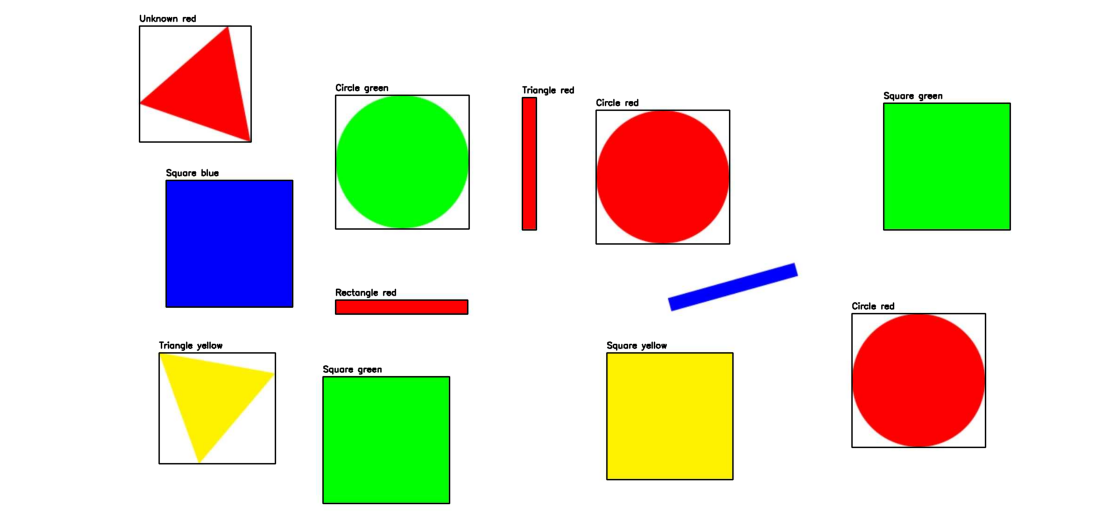

In [102]:
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 8))
plt.imshow(output_rgb)
plt.axis("off")
plt.show()